In [3]:
import numpy as np
import pandas as pd
import scipy.integrate as spi
from cmdstanpy import CmdStanModel
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import dual_annealing
from datetime import timedelta

In [4]:
# Barangay Population
population = 407437

df_barangay = pd.read_csv('combined_binan_actual_cases.csv', parse_dates=['date'])
df = df_barangay[df_barangay['barangay_Res'] == 'Biñan']

# training and tests of different time range
train_data_test1 = df[(df['date'] >= '2021-05-13') & 
                    (df['date'] <= '2022-01-13') 
                    ]
train_data_test2 = df[(df['date'] >= '2021-06-13') & 
                    (df['date'] <= '2022-01-13') 
                    ]
train_data_test3 = df[(df['date'] >= '2021-08-13') & 
                    (df['date'] <= '2022-01-13') 
                    ]
train_data_test4 = df[(df['date'] >= '2021-10-13') & 
                    (df['date'] <= '2022-01-13') 
                    ]
test_data = df[(df['date'] >= '2022-01-14') & 
                   (df['date'] <= '2022-02-13') 
                  ]


# Setting number of days of training and prediction
n_days_train1 = len(train_data_test1)
n_days_train2 = len(train_data_test2)
n_days_train3 = len(train_data_test3)
n_days_train4 = len(train_data_test4)
n_pred_days = len(test_data)

# Getting the number of different compartment on different days
train_cases_test1 = train_data_test1['count_Conf_age_60_79'].values
train_cases_test2 = train_data_test2['count_Conf_age_60_79'].values
train_cases_test3 = train_data_test3['count_Conf_age_60_79'].values
train_cases_test4 = train_data_test4['count_Conf_age_60_79'].values
test_cases = test_data['count_Conf_age_60_79'].values

results = []

In [ ]:
model = CmdStanModel(stan_file='../seir_model.stan')

def seir_ode(y, t,  beta, sigma, gamma):
    S, E, I, R = y
    dS_dt = -beta * I * S / population
    dE_dt = beta * I * S / population - sigma * E
    dI_dt = sigma * E - gamma * I
    dR_dt = gamma * I
    return [dS_dt, dE_dt, dI_dt, dR_dt]

def objective_function(params, cases,initial_conditions):
    beta, sigma, gamma = params
    t = np.arange(len(cases))
    
    # Solve SEIR Model
    solution = odeint(seir_ode, initial_conditions, t, args=(beta, sigma, gamma))
    I_pred = solution[:, 2]  # Predicted Infected
    I_pred = np.clip(I_pred, 0, None)  # Ensure non-negative predictions

    # Calculate Error
    I_actual = cases
    error = np.mean((I_pred - I_actual) ** 2)
    
    # Regularization term to prevent extreme parameter values
    reg_term = 0.01 * (beta ** 2 + sigma ** 2 + gamma ** 2)
    
    return error + reg_term

bounds = [(0.0001, 2.0), (0.0001, 1.0), (0.0001, 1.0)]  # Wider bounds


def get_initial_state(train_data):
    E = train_data['count_Specimen_age_60_79'].values[0]
    I = train_data['count_Conf_age_60_79'].values[0]
    R = train_data['count_Reco_age_60_79'].values[0]
    S = population - E - I - R
    initial_conditions = [S, E, I, R]

    e_test = train_data['count_Specimen_age_60_79'].values[-1]
    i_test = train_data['count_Conf_age_60_79'].values[-1]
    r_test = train_data['count_Reco_age_60_79'].values[-1]
    s_test = population - e_test - i_test - r_test
    initial_conditions_test = [s_test, e_test,i_test, r_test]
    return initial_conditions, initial_conditions_test


# Getting the arranged days of all training sets
def get_arrange_days(train_data,test_data):
    return np.arange(len(train_data)), np.arange(len(train_data), len(train_data) + len(test_data) )





# Test 1: 8 months Training | 1 Month Training

# Bayesian

In [6]:

stan_data = {
    "n_days": n_days_train1, # number of days the model will be trained
    "t0": 0, # initial state
    "ts": np.arange(1, n_days_train1 + 1), # time steps
    "N": int(population), 
    "cases": train_cases_test1.tolist(), # active cases on different days
    "i0": train_cases_test1[0] ,  # Initial infectious individuals
    "e0":train_data_test1['count_Specimen_age_60_79'].values[0],  # Initial exposed individuals
    "r0":train_data_test1['count_Reco_age_60_79'].values[0],  # Initial recovered individuals
}

fit = model.sample(data=stan_data, iter_warmup=500, iter_sampling=500, chains=4, parallel_chains=4,adapt_delta=0.9, seed=42)


lambda_ = np.mean(fit.stan_variable("infectious_rate"))
sigma = np.mean(fit.stan_variable("incubation_rate"))
gamma = np.mean(fit.stan_variable("recovery_rate"))
beta = lambda_
gamma = gamma

print(f'beta: {beta}, gamma: {gamma}, sigma: {sigma}')



initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test1)
t_train, t_test = get_arrange_days(train_data_test1,test_data)


predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_bayesian = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_bayesian = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)

mae_bayesian = mean_absolute_error(I_pred_test_bayesian, test_cases )
norm_factor = np.mean(np.abs(test_cases))
nmae_bayesian = mae_bayesian / norm_factor
mse_bayesian = mean_squared_error(test_cases,I_pred_test_bayesian)
rmse_bayesian = np.sqrt(mse_bayesian)


print(f"MAE : {mae_bayesian}, NMAE: {nmae_bayesian}, MSE: {mse_bayesian}, RMSE: {rmse_bayesian}")


results.append(["Test 1: Bayesian",   mse_bayesian, rmse_bayesian,mae_bayesian, nmae_bayesian,beta,  sigma,gamma])


15:59:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▋        | 00:28 Iteration:   1 / 1000 [  0%]  (Warmup)




chain 1 |██▌       | 01:36 Iteration: 100 / 1000 [ 10%]  (Warmup)





chain 1 |███▎      | 03:09 Iteration: 200 / 1000 [ 20%]  (Warmup)




chain 1 |████▏     | 04:29 Iteration: 300 / 1000 [ 30%]  (Warmup)



chain 1 |█████▊    | 06:03 Iteration: 500 / 1000 [ 50%]  (Warmup)


chain 1 |███████▌  | 08:14 Iteration: 600 / 1000 [ 60%]  (Sampling)


chain 1 |████████▎ | 09:08 Iteration: 700 / 1000 [ 70%]  (Sampling)


chain 1 |█████████▏| 10:05 Iteration: 800 / 1000 [ 80%]  (Sampling)


chain 1 |██████████| 11:01 Iteration: 900 / 1000 [ 90%]  (Sampling)
chain 1 |██████████| 12:05 Sampling completed                      
chain 2 |██████████| 12:05 Sampling completed                      
chain 3 |██████████| 12:05 Sampling completed                      
chain 4 |██████████| 12:05 Sampling completed                      


16:11:57 - cmdstanpy - INFO - CmdStan done processing.


16:11:57 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


beta: 0.837906092, gamma: 0.8261068605, sigma: 0.821210819
MAE : 31.530517850826463, NMAE: 0.44248350084908117, MSE: 1275.4695416450782, RMSE: 35.713716435636854


# Simulated Annealing

In [7]:

initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test1)
t_train, t_test = get_arrange_days(train_data_test1,test_data)

result = dual_annealing(objective_function, bounds, args=(train_cases_test1,initial_conditions,))
beta, sigma, gamma = result.x

print(f"beta: {beta}, sigma: {sigma}, gamma: {gamma}")

predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_annealing = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_annealing = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)

mae_annealing = mean_absolute_error(I_pred_test_annealing, test_cases )
norm_factor = np.mean(np.abs(test_cases))
nmae_annealing = mae_annealing / norm_factor
mse_annealing = mean_squared_error(test_cases,I_pred_test_annealing)
rmse_annealing = np.sqrt(mse_annealing)



print(f"MAE : {mae_annealing}, NMAE: {nmae_annealing}, MSE: {mse_annealing}, RMSE: {rmse_annealing}")
results.append(["Test 1: Annealing",   mse_annealing, rmse_annealing,mae_annealing, nmae_annealing,beta, sigma,gamma ])


beta: 1.010810314121202, sigma: 0.9999832370942048, gamma: 1.0
MAE : 30.709315946683137, NMAE: 0.43095916448491495, MSE: 1197.3889172341921, RMSE: 34.60330789439345


# SEIR

In [8]:

initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test1)
t_train, t_test = get_arrange_days(train_data_test1,test_data)

beta = 2.93  # Infection rate
sigma = 0.28  # Incubation rate
gamma = 0.33  # Recovery rate


predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_seir = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_seir = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)


# Evaluate the model (using test_cases for evaluation)
mae_seir = mean_absolute_error(test_cases, I_pred_test_seir)
norm_factor = np.mean(np.abs(test_cases))
nmae_seir = mae_seir / norm_factor
mse_seir = mean_squared_error(test_cases, I_pred_test_seir)
rmse_seir = mse_seir ** (1/2)

print(f"MAE : {mae_seir}, NMAE: {nmae_seir}, MSE: {mse_seir}, RMSE: {rmse_seir}")
results.append(["Test 1: SEIR 1",   mse_seir, rmse_seir,mae_seir, nmae_seir,beta, sigma,gamma])


MAE : 38466.21400474751, NMAE: 539.8155881155151, MSE: 2856434686.7359123, RMSE: 53445.623644372536


# SEIR 2

In [9]:

initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test1)
t_train, t_test = get_arrange_days(train_data_test1,test_data)

beta = 0.198  # Infection rate
sigma = 0.3  # Incubation rate
gamma = 0.1389  # Recovery rate

predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_seir2 = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_seir2 = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)


# Evaluate the model (using test_cases for evaluation)
mae_seir2 = mean_absolute_error(test_cases, I_pred_test_seir2)
norm_factor = np.mean(np.abs(test_cases))
nmae_seir2 = mae_seir2 / norm_factor
mse_seir2 = mean_squared_error(test_cases, I_pred_test_seir2)
rmse_seir2 = mse_seir2 ** (1/2)

print(f"MAE : {mae_seir2}, NMAE: {nmae_seir2}, MSE: {mse_seir2}, RMSE: {rmse_seir2}")
results.append(["Test 1: SEIR 2",   mse_seir2, rmse_seir2,mae_seir2, nmae_seir2,beta, sigma,gamma])


MAE : 107.10995006507717, NMAE: 1.503127411506289, MSE: 19109.04162048923, RMSE: 138.23545717539054


# Result

Bayesian
MAE : 31.530517850826463, NMAE: 0.44248350084908117, MSE: 1275.4695416450782, RMSE: 35.713716435636854
Simulated Annealing
MAE : 30.709315946683137, NMAE: 0.43095916448491495, MSE: 1197.3889172341921, RMSE: 34.60330789439345
SEIR
MAE : 38466.21400474751, NMAE: 539.8155881155151, MSE: 2856434686.7359123, RMSE: 53445.623644372536


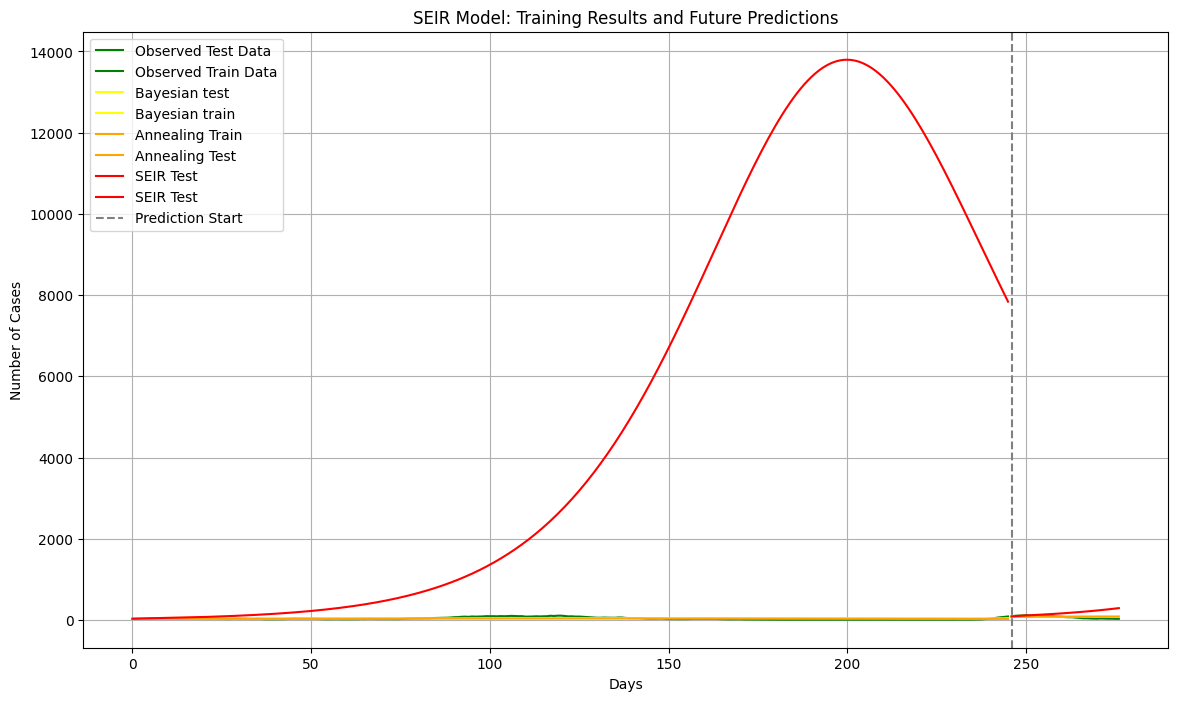

In [10]:
print("Bayesian")
print(f"MAE : {mae_bayesian}, NMAE: {nmae_bayesian}, MSE: {mse_bayesian}, RMSE: {rmse_bayesian}")
print("Simulated Annealing")
print(f"MAE : {mae_annealing}, NMAE: {nmae_annealing}, MSE: {mse_annealing}, RMSE: {rmse_annealing}")
print("SEIR")
print(f"MAE : {mae_seir}, NMAE: {nmae_seir}, MSE: {mse_seir}, RMSE: {rmse_seir}")
plt.figure(figsize=(14, 8))

# plt.plot(t_train, train_cases_test1,label="Observed Train Data", color="red")
# Plot observed cases for training
plt.plot(t_test, test_cases, label="Observed Test Data", color="green")
plt.plot(t_train, train_cases_test1,label="Observed Train Data", color="green")


# Plot model results for training
plt.plot(t_test, I_pred_test_bayesian, label="Bayesian test", color="yellow")
plt.plot(t_train, I_pred_train_bayesian, label="Bayesian train", color="yellow")
# Plot model results for training
plt.plot(t_train, I_pred_train_annealing,label="Annealing Train", color="orange")
plt.plot(t_test, I_pred_test_annealing, label="Annealing Test", color="orange")

plt.plot(t_test, I_pred_test_seir2, label="SEIR Test", color="red")
plt.plot(t_train, I_pred_train_seir2, label="SEIR Test", color="red")

# Add labels and legend
plt.axvline(x=len(I_pred_train_bayesian), linestyle='--', color='gray', label="Prediction Start")
plt.xlabel("Days")
plt.ylabel("Number of Cases")
plt.title("SEIR Model: Training Results and Future Predictions")
plt.legend()
plt.grid()
plt.show()

without seir

Bayesian
MAE : 31.530517850826463, NMAE: 0.44248350084908117, MSE: 1275.4695416450782, RMSE: 35.713716435636854
Simulated Annealing
MAE : 30.709315946683137, NMAE: 0.43095916448491495, MSE: 1197.3889172341921, RMSE: 34.60330789439345


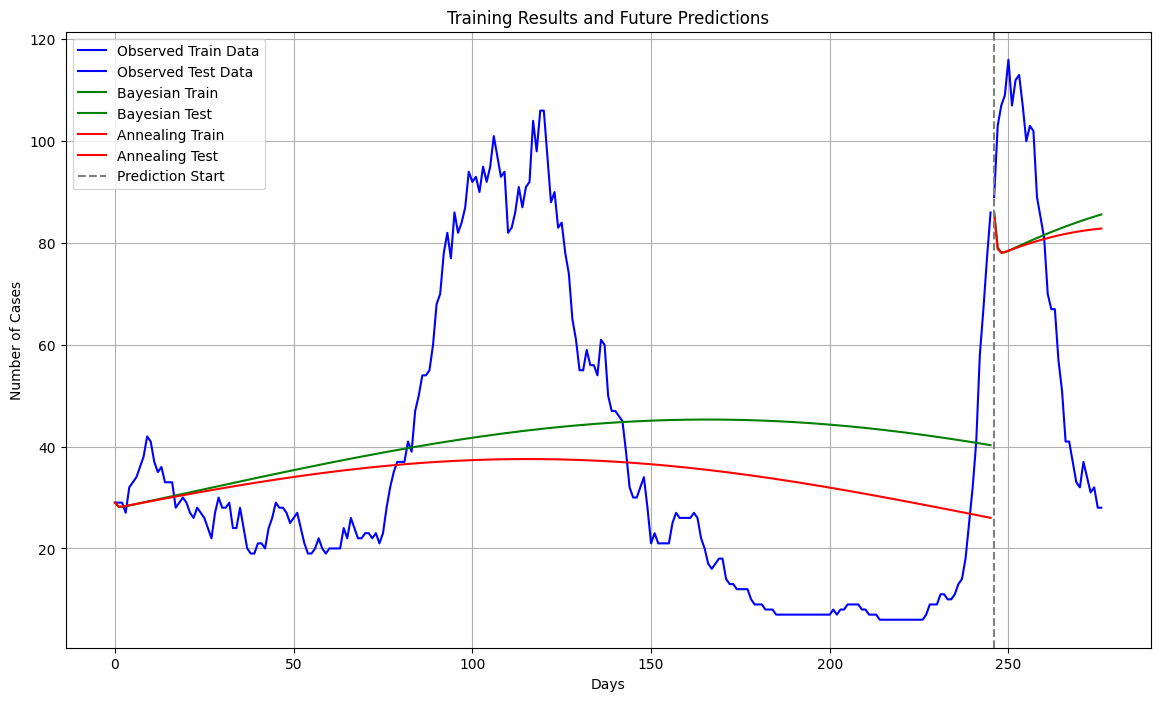

In [11]:
print("Bayesian")
print(f"MAE : {mae_bayesian}, NMAE: {nmae_bayesian}, MSE: {mse_bayesian}, RMSE: {rmse_bayesian}")
print("Simulated Annealing")
print(f"MAE : {mae_annealing}, NMAE: {nmae_annealing}, MSE: {mse_annealing}, RMSE: {rmse_annealing}")


plt.figure(figsize=(14, 8))

# Plot observed data
plt.plot(t_train, train_cases_test1,label="Observed Train Data", color="blue")
plt.plot(t_test, test_cases, label="Observed Test Data", color="blue")

# Bayesian Plot
plt.plot(t_train, I_pred_train_bayesian,label="Bayesian Train", color="green")
plt.plot(t_test, I_pred_test_bayesian, label="Bayesian Test", color="green")

# Annealing plot
plt.plot(t_train, I_pred_train_annealing,label="Annealing Train", color="red")
plt.plot(t_test, I_pred_test_annealing, label="Annealing Test", color="red")
#plt.plot(t_test, I_pred_test_seir, label="Annealing Test", color="orange")


# Add labels and legend
plt.axvline(x=len(I_pred_train_bayesian), linestyle='--', color='gray', label="Prediction Start")
plt.xlabel("Days")
plt.ylabel("Number of Cases")
plt.title("Training Results and Future Predictions")
plt.legend()
plt.grid()
plt.show()


# Test 2:  7 Months Training | 1 Month Prediction

# Bayesian

In [12]:

stan_data = {
    "n_days": n_days_train2, # number of days the model will be trained
    "t0": 0, # initial state
    "ts": np.arange(1, n_days_train2 + 1), # time steps
    "N": int(population), 
    "cases": train_cases_test2.tolist(), # active cases on different days
    "i0": train_cases_test2[0] ,  # Initial infectious individuals
    "e0":train_data_test2['count_Specimen_age_60_79'].values[0],  # Initial exposed individuals
    "r0":train_data_test2['count_Reco_age_60_79'].values[0],  # Initial recovered individuals
}

fit = model.sample(data=stan_data, iter_warmup=500, iter_sampling=500, chains=4, parallel_chains=4,adapt_delta=0.9, seed=42)


lambda_ = np.mean(fit.stan_variable("infectious_rate"))
sigma = np.mean(fit.stan_variable("incubation_rate"))
gamma = np.mean(fit.stan_variable("recovery_rate"))
beta = lambda_
gamma = gamma

print(f'beta: {beta}, gamma: {gamma}, sigma: {sigma}')

initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test2)
t_train, t_test = get_arrange_days(train_data_test2,test_data)


predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_bayesian = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_bayesian = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)

mae_bayesian = mean_absolute_error(I_pred_test_bayesian, test_cases )
norm_factor = np.mean(np.abs(test_cases))
nmae_bayesian = mae_bayesian / norm_factor
mse_bayesian = mean_squared_error(test_cases,I_pred_test_bayesian)
rmse_bayesian = np.sqrt(mse_bayesian)


print(f"MAE : {mae_bayesian}, NMAE: {nmae_bayesian}, MSE: {mse_bayesian}, RMSE: {rmse_bayesian}")
results.append(["Test 2: Bayesian",   mse_bayesian, rmse_bayesian,mae_bayesian, nmae_bayesian,beta,  sigma,gamma])




16:12:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▋        | 00:13 Iteration:   1 / 1000 [  0%]  (Warmup)






chain 1 |██▌       | 00:55 Iteration: 100 / 1000 [ 10%]  (Warmup)






chain 1 |███▎      | 01:37 Iteration: 200 / 1000 [ 20%]  (Warmup)




chain 1 |████▏     | 02:18 Iteration: 300 / 1000 [ 30%]  (Warmup)




chain 1 |█████▊    | 03:08 Iteration: 500 / 1000 [ 50%]  (Warmup)

chain 1 |██████▋   | 03:44 Iteration: 501 / 1000 [ 50%]  (Sampling)

chain 1 |███████▌  | 04:34 Iteration: 600 / 1000 [ 60%]  (Sampling)
chain 1 |████████▎ | 05:19 Iteration: 700 / 1000 [ 70%]  (Sampling)

chain 1 |██████████| 06:50 Sampling completed                      
chain 2 |██████████| 06:50 Sampling completed                      
chain 3 |██████████| 06:50 Sampling completed                      
chain 4 |██████████| 06:50 Sampling completed                      


16:19:11 - cmdstanpy - INFO - CmdStan done processing.


16:19:11 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 27 divergent transitions (5.4%)
	Chain 4 had 16 divergent transitions (3.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


beta: 0.8818208970000001, gamma: 0.8361981940000001, sigma: 0.859967541
MAE : 49.941651602999336, NMAE: 0.7008561338582976, MSE: 3846.086856740807, RMSE: 62.01682720633818


# Simulated Annealing

In [13]:

initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test2)
t_train, t_test = get_arrange_days(train_data_test2,test_data)

result = dual_annealing(objective_function, bounds, args=(train_cases_test2,initial_conditions,))
beta, sigma, gamma = result.x

print(f"beta: {beta}, sigma: {sigma}, gamma: {gamma}")

predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_annealing = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_annealing = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)

mae_annealing = mean_absolute_error(I_pred_test_annealing, test_cases )
norm_factor = np.mean(np.abs(test_cases))
nmae_annealing = mae_annealing / norm_factor
mse_annealing = mean_squared_error(test_cases,I_pred_test_annealing)
rmse_annealing = np.sqrt(mse_annealing)



print(f"MAE : {mae_annealing}, NMAE: {nmae_annealing}, MSE: {mse_annealing}, RMSE: {rmse_annealing}")
results.append(["Test 2: Annealing",   mse_annealing, rmse_annealing,mae_annealing, nmae_annealing,beta, sigma,gamma ])


beta: 0.11497890895828795, sigma: 1.0, gamma: 0.11836872852373526
MAE : 58.665141685004045, NMAE: 0.8232772260005093, MSE: 4385.303193629719, RMSE: 66.22162179854642


# SEIR

In [14]:

initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test2)
t_train, t_test = get_arrange_days(train_data_test2,test_data)

beta = 2.93  # Infection rate
sigma = 0.28  # Incubation rate
gamma = 0.33  # Recovery rate


predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_seir = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_seir = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)


# Evaluate the model (using test_cases for evaluation)
mae_seir = mean_absolute_error(test_cases, I_pred_test_seir)
norm_factor = np.mean(np.abs(test_cases))
nmae_seir = mae_seir / norm_factor
mse_seir = mean_squared_error(test_cases, I_pred_test_seir)
rmse_seir = mse_seir ** (1/2)

print(f"MAE : {mae_seir}, NMAE: {nmae_seir}, MSE: {mse_seir}, RMSE: {rmse_seir}")
results.append(["Test 2: SEIR 1",   mse_seir, rmse_seir,mae_seir, nmae_seir,beta, sigma,gamma])



MAE : 38466.21400474726, NMAE: 539.8155881155114, MSE: 2856434686.735883, RMSE: 53445.62364437226


# SEIR 2

In [15]:
initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test2)
t_train, t_test = get_arrange_days(train_data_test2,test_data)

beta = 0.198  # Infection rate
sigma = 0.3  # Incubation rate
gamma = 0.1389  # Recovery rate

predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_seir2 = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_seir2 = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)


# Evaluate the model (using test_cases for evaluation)
mae_seir2 = mean_absolute_error(test_cases, I_pred_test_seir2)
norm_factor = np.mean(np.abs(test_cases))
nmae_seir2 = mae_seir2 / norm_factor
mse_seir2 = mean_squared_error(test_cases, I_pred_test_seir2)
rmse_seir2 = mse_seir2 ** (1/2)

print(f"MAE : {mae_seir2}, NMAE: {nmae_seir2}, MSE: {mse_seir2}, RMSE: {rmse_seir2}")
results.append(["Test 2: SEIR 2",   mse_seir2, rmse_seir2,mae_seir2, nmae_seir2,beta, sigma,gamma])

MAE : 107.10995006507538, NMAE: 1.5031274115062636, MSE: 19109.041620488475, RMSE: 138.2354571753878



# Result

Bayesian
MAE : 49.941651602999336, NMAE: 0.7008561338582976, MSE: 3846.086856740807, RMSE: 62.01682720633818
Simulated Annealing
MAE : 58.665141685004045, NMAE: 0.8232772260005093, MSE: 4385.303193629719, RMSE: 66.22162179854642
SEIR
MAE : 38466.21400474726, NMAE: 539.8155881155114, MSE: 2856434686.735883, RMSE: 53445.62364437226
SEIR 2
MAE : 107.10995006507538, NMAE: 1.5031274115062636, MSE: 19109.041620488475, RMSE: 138.2354571753878


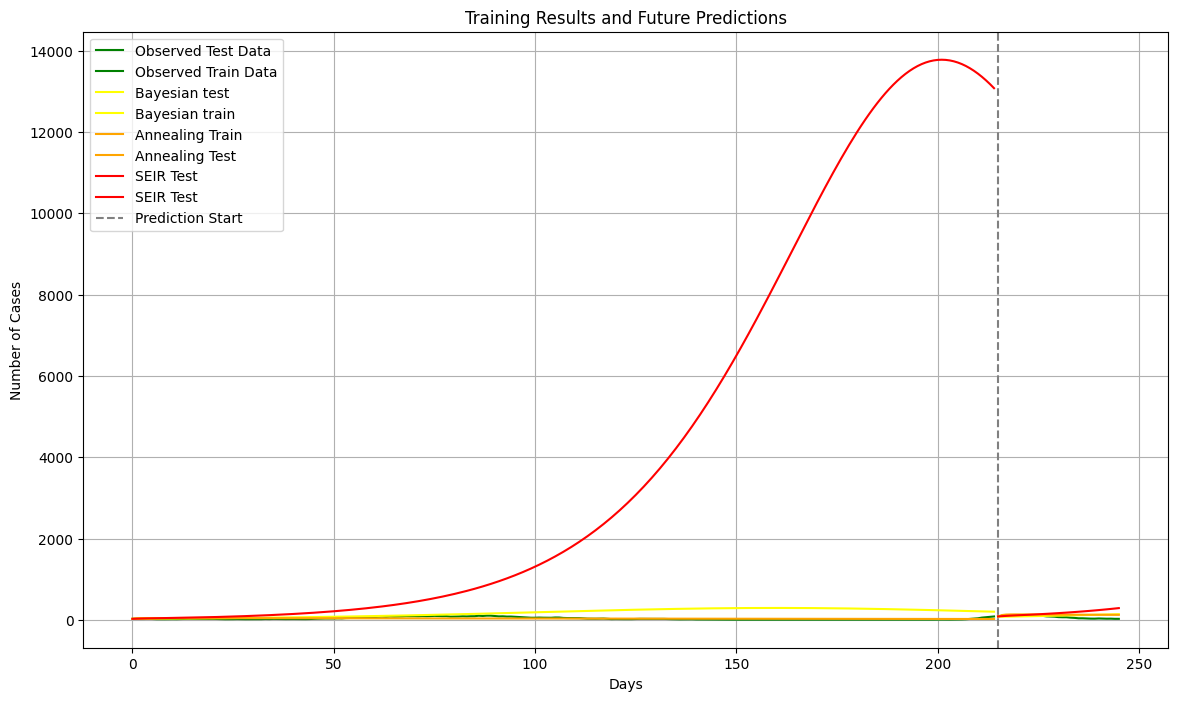

In [16]:
print("Bayesian")
print(f"MAE : {mae_bayesian}, NMAE: {nmae_bayesian}, MSE: {mse_bayesian}, RMSE: {rmse_bayesian}")
print("Simulated Annealing")
print(f"MAE : {mae_annealing}, NMAE: {nmae_annealing}, MSE: {mse_annealing}, RMSE: {rmse_annealing}")
print("SEIR")
print(f"MAE : {mae_seir}, NMAE: {nmae_seir}, MSE: {mse_seir}, RMSE: {rmse_seir}")
print("SEIR 2")
print(f"MAE : {mae_seir2}, NMAE: {nmae_seir2}, MSE: {mse_seir2}, RMSE: {rmse_seir2}")


plt.figure(figsize=(14, 8))


plt.plot(t_test, test_cases, label="Observed Test Data", color="green")
plt.plot(t_train, train_cases_test2,label="Observed Train Data", color="green")


# Plot model results for training
plt.plot(t_test, I_pred_test_bayesian, label="Bayesian test", color="yellow")
plt.plot(t_train, I_pred_train_bayesian, label="Bayesian train", color="yellow")

# Plot model results for training
plt.plot(t_train, I_pred_train_annealing,label="Annealing Train", color="orange")
plt.plot(t_test, I_pred_test_annealing, label="Annealing Test", color="orange")

plt.plot(t_test, I_pred_test_seir2, label="SEIR Test", color="red")
plt.plot(t_train, I_pred_train_seir2, label="SEIR Test", color="red")

# Add labels and legend
plt.axvline(x=len(I_pred_train_bayesian), linestyle='--', color='gray', label="Prediction Start")
plt.xlabel("Days")
plt.ylabel("Number of Cases")
plt.title("Training Results and Future Predictions")
plt.legend()
plt.grid()
plt.show()

Without SEIR

Bayesian
MAE : 49.941651602999336, NMAE: 0.7008561338582976, MSE: 3846.086856740807, RMSE: 62.01682720633818
Simulated Annealing
MAE : 58.665141685004045, NMAE: 0.8232772260005093, MSE: 4385.303193629719, RMSE: 66.22162179854642


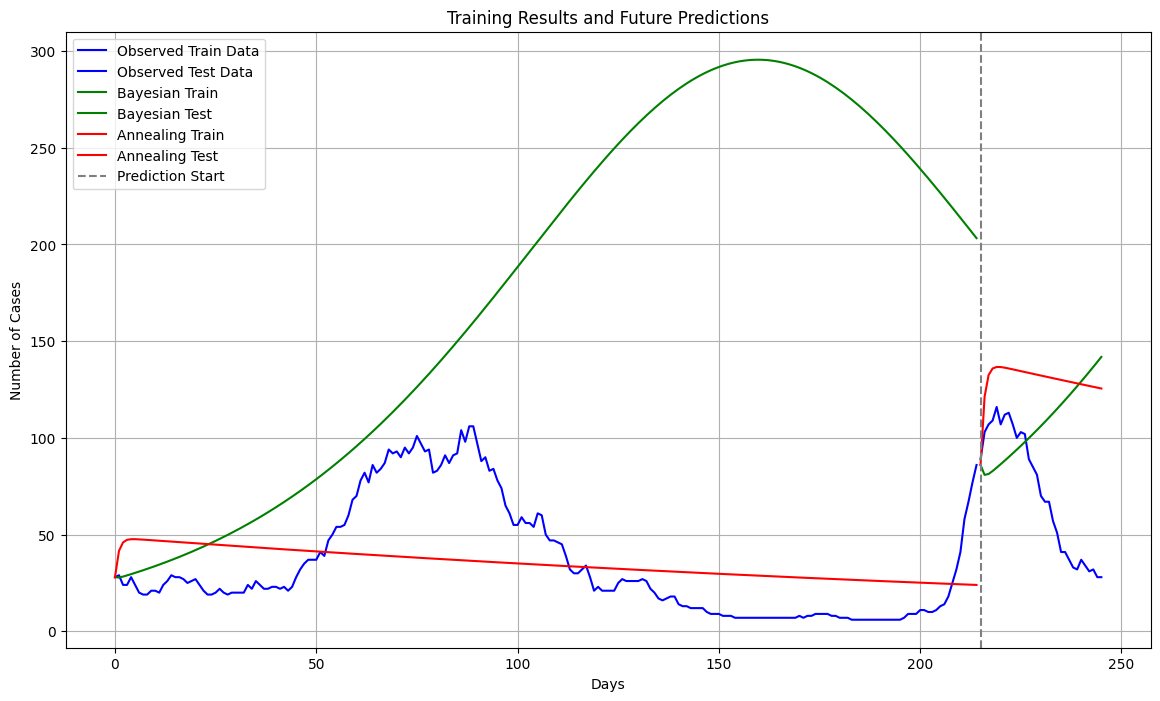

In [17]:
print("Bayesian")
print(f"MAE : {mae_bayesian}, NMAE: {nmae_bayesian}, MSE: {mse_bayesian}, RMSE: {rmse_bayesian}")
print("Simulated Annealing")
print(f"MAE : {mae_annealing}, NMAE: {nmae_annealing}, MSE: {mse_annealing}, RMSE: {rmse_annealing}")



plt.figure(figsize=(14, 8))

# Plot observed data
plt.plot(t_train, train_cases_test2,label="Observed Train Data", color="blue")
plt.plot(t_test, test_cases, label="Observed Test Data", color="blue")

# Bayesian Plot
plt.plot(t_train, I_pred_train_bayesian,label="Bayesian Train", color="green")
plt.plot(t_test, I_pred_test_bayesian, label="Bayesian Test", color="green")

# Annealing plot
plt.plot(t_train, I_pred_train_annealing,label="Annealing Train", color="red")
plt.plot(t_test, I_pred_test_annealing, label="Annealing Test", color="red")
#plt.plot(t_test, I_pred_test_seir, label="Annealing Test", color="orange")


# Add labels and legend
plt.axvline(x=len(I_pred_train_bayesian), linestyle='--', color='gray', label="Prediction Start")
plt.xlabel("Days")
plt.ylabel("Number of Cases")
plt.title("Training Results and Future Predictions")
plt.legend()
plt.grid()
plt.show()

# Test 3: 5 Months Training | 1 Month Prediction

# Bayesian

In [18]:

stan_data = {
    "n_days": n_days_train3, # number of days the model will be trained
    "t0": 0, # initial state
    "ts": np.arange(1, n_days_train3 + 1), # time steps
    "N": int(population), 
    "cases": train_cases_test3.tolist(), # active cases on different days
    "i0": train_cases_test3[0] ,  # Initial infectious individuals
    "e0":train_data_test3['count_Specimen_age_60_79'].values[0],  # Initial exposed individuals
    "r0":train_data_test3['count_Reco_age_60_79'].values[0],  # Initial recovered individuals
}

fit = model.sample(data=stan_data, iter_warmup=500, iter_sampling=500, chains=4, parallel_chains=4,adapt_delta=0.9, seed=42)


lambda_ = np.mean(fit.stan_variable("infectious_rate"))
sigma = np.mean(fit.stan_variable("incubation_rate"))
gamma = np.mean(fit.stan_variable("recovery_rate"))
beta = lambda_
gamma = gamma

print(f'beta: {beta}, gamma: {gamma}, sigma: {sigma}')



initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test3)
t_train, t_test = get_arrange_days(train_data_test3,test_data)


predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_bayesian = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_bayesian = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)

mae_bayesian = mean_absolute_error(I_pred_test_bayesian, test_cases )
norm_factor = np.mean(np.abs(test_cases))
nmae_bayesian = mae_bayesian / norm_factor
mse_bayesian = mean_squared_error(test_cases,I_pred_test_bayesian)
rmse_bayesian = np.sqrt(mse_bayesian)


print(f"MAE : {mae_bayesian}, NMAE: {nmae_bayesian}, MSE: {mse_bayesian}, RMSE: {rmse_bayesian}")

results.append(["Test 3: Bayesian",   mse_bayesian, rmse_bayesian,mae_bayesian, nmae_bayesian,beta,  sigma,gamma])



16:19:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▋        | 00:16 Iteration:   1 / 1000 [  0%]  (Warmup)


chain 1 |██▌       | 00:44 Iteration: 100 / 1000 [ 10%]  (Warmup)


chain 1 |███▎      | 01:11 Iteration: 200 / 1000 [ 20%]  (Warmup)



chain 1 |████▏     | 01:40 Iteration: 300 / 1000 [ 30%]  (Warmup)






chain 1 |█████▊    | 02:11 Iteration: 500 / 1000 [ 50%]  (Warmup)


chain 1 |██████▋   | 02:38 Iteration: 501 / 1000 [ 50%]  (Sampling)


chain 1 |███████▌  | 02:56 Iteration: 600 / 1000 [ 60%]  (Sampling)


chain 1 |████████▎ | 03:13 Iteration: 700 / 1000 [ 70%]  (Sampling)


chain 1 |█████████▏| 03:28 Iteration: 800 / 1000 [ 80%]  (Sampling)


chain 1 |██████████| 04:46 Sampling completed                      
chain 2 |██████████| 04:46 Sampling completed                      
chain 3 |██████████| 04:46 Sampling completed                      
chain 4 |██████████| 04:46 Sampling completed                      


16:24:11 - cmdstanpy - INFO - CmdStan done processing.



beta: 0.6810198215000001, gamma: 0.6929184225, sigma: 0.676149427
MAE : 24.839589374906904, NMAE: 0.34858636062567405, MSE: 751.2478541531773, RMSE: 27.408901002287145


# Simulated Annealing

In [19]:

initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test3)
t_train, t_test = get_arrange_days(train_data_test3,test_data)

result = dual_annealing(objective_function, bounds, args=(train_cases_test3,initial_conditions,))
beta, sigma, gamma = result.x

print(f"beta: {beta}, sigma: {sigma}, gamma: {gamma}")

predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_annealing = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_annealing = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)

mae_annealing = mean_absolute_error(I_pred_test_annealing, test_cases )
norm_factor = np.mean(np.abs(test_cases))
nmae_annealing = mae_annealing / norm_factor
mse_annealing = mean_squared_error(test_cases,I_pred_test_annealing)
rmse_annealing = np.sqrt(mse_annealing)



print(f"MAE : {mae_annealing}, NMAE: {nmae_annealing}, MSE: {mse_annealing}, RMSE: {rmse_annealing}")

results.append(["Test 3: Annealing",   mse_annealing, rmse_annealing,mae_annealing, nmae_annealing,beta, sigma,gamma ])

beta: 0.0001, sigma: 0.10159905301459557, gamma: 0.026830299818496064
MAE : 28.19987843516255, NMAE: 0.39574297487099996, MSE: 1172.3767921518572, RMSE: 34.23998820315009


# SEIR

In [20]:

initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test3)
t_train, t_test = get_arrange_days(train_data_test3,test_data)

beta = 2.93  # Infection rate
sigma = 0.28  # Incubation rate
gamma = 0.33  # Recovery rate


predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_seir = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_seir = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)


# Evaluate the model (using test_cases for evaluation)
mae_seir = mean_absolute_error(test_cases, I_pred_test_seir)
norm_factor = np.mean(np.abs(test_cases))
nmae_seir = mae_seir / norm_factor
mse_seir = mean_squared_error(test_cases, I_pred_test_seir)
rmse_seir = mse_seir ** (1/2)

print(f"MAE : {mae_seir}, NMAE: {nmae_seir}, MSE: {mse_seir}, RMSE: {rmse_seir}")

results.append(["Test 3: SEIR 1",   mse_seir, rmse_seir,mae_seir, nmae_seir,beta, sigma,gamma])

MAE : 38466.2140047477, NMAE: 539.8155881155177, MSE: 2856434686.735947, RMSE: 53445.623644372856


# SEIR 2

In [21]:

initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test3)
t_train, t_test = get_arrange_days(train_data_test3,test_data)

beta = 0.198  # Infection rate
sigma = 0.3  # Incubation rate
gamma = 0.1389  # Recovery rate

predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_seir2 = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_seir2 = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)


# Evaluate the model (using test_cases for evaluation)
mae_seir2 = mean_absolute_error(test_cases, I_pred_test_seir2)
norm_factor = np.mean(np.abs(test_cases))
nmae_seir2 = mae_seir2 / norm_factor
mse_seir2 = mean_squared_error(test_cases, I_pred_test_seir2)
rmse_seir2 = mse_seir2 ** (1/2)

print(f"MAE : {mae_seir2}, NMAE: {nmae_seir2}, MSE: {mse_seir2}, RMSE: {rmse_seir2}")
results.append(["Test 3: SEIR 2",   mse_seir2, rmse_seir2,mae_seir2, nmae_seir2,beta, sigma,gamma])

MAE : 107.10995006507541, NMAE: 1.503127411506264, MSE: 19109.041620488544, RMSE: 138.23545717538806


# Result

Bayesian
MAE : 24.839589374906904, NMAE: 0.34858636062567405, MSE: 751.2478541531773, RMSE: 27.408901002287145
Simulated Annealing
MAE : 28.19987843516255, NMAE: 0.39574297487099996, MSE: 1172.3767921518572, RMSE: 34.23998820315009
SEIR
MAE : 38466.2140047477, NMAE: 539.8155881155177, MSE: 2856434686.735947, RMSE: 53445.623644372856
SEIR 2
MAE : 107.10995006507541, NMAE: 1.503127411506264, MSE: 19109.041620488544, RMSE: 138.23545717538806


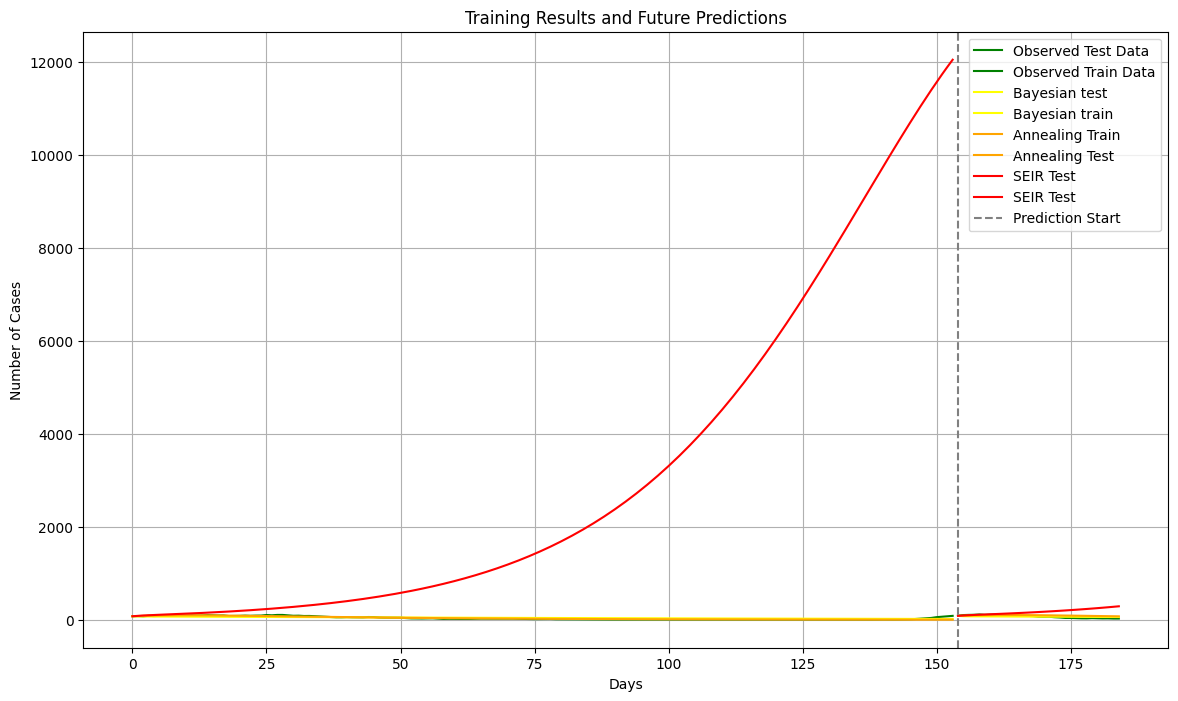

In [22]:
print("Bayesian")
print(f"MAE : {mae_bayesian}, NMAE: {nmae_bayesian}, MSE: {mse_bayesian}, RMSE: {rmse_bayesian}")
print("Simulated Annealing")
print(f"MAE : {mae_annealing}, NMAE: {nmae_annealing}, MSE: {mse_annealing}, RMSE: {rmse_annealing}")
print("SEIR")
print(f"MAE : {mae_seir}, NMAE: {nmae_seir}, MSE: {mse_seir}, RMSE: {rmse_seir}")
print("SEIR 2")
print(f"MAE : {mae_seir2}, NMAE: {nmae_seir2}, MSE: {mse_seir2}, RMSE: {rmse_seir2}")


plt.figure(figsize=(14, 8))


plt.plot(t_test, test_cases, label="Observed Test Data", color="green")
plt.plot(t_train, train_cases_test3,label="Observed Train Data", color="green")


# Plot model results for training
plt.plot(t_test, I_pred_test_bayesian, label="Bayesian test", color="yellow")
plt.plot(t_train, I_pred_train_bayesian, label="Bayesian train", color="yellow")

# Plot model results for training
plt.plot(t_train, I_pred_train_annealing,label="Annealing Train", color="orange")
plt.plot(t_test, I_pred_test_annealing, label="Annealing Test", color="orange")

plt.plot(t_test, I_pred_test_seir2, label="SEIR Test", color="red")
plt.plot(t_train, I_pred_train_seir2, label="SEIR Test", color="red")

# Add labels and legend
plt.axvline(x=len(I_pred_train_bayesian), linestyle='--', color='gray', label="Prediction Start")
plt.xlabel("Days")
plt.ylabel("Number of Cases")
plt.title("Training Results and Future Predictions")
plt.legend()
plt.grid()
plt.show()

Without SEIR

Bayesian
MAE : 24.839589374906904, NMAE: 0.34858636062567405, MSE: 751.2478541531773, RMSE: 27.408901002287145
Simulated Annealing
MAE : 28.19987843516255, NMAE: 0.39574297487099996, MSE: 1172.3767921518572, RMSE: 34.23998820315009


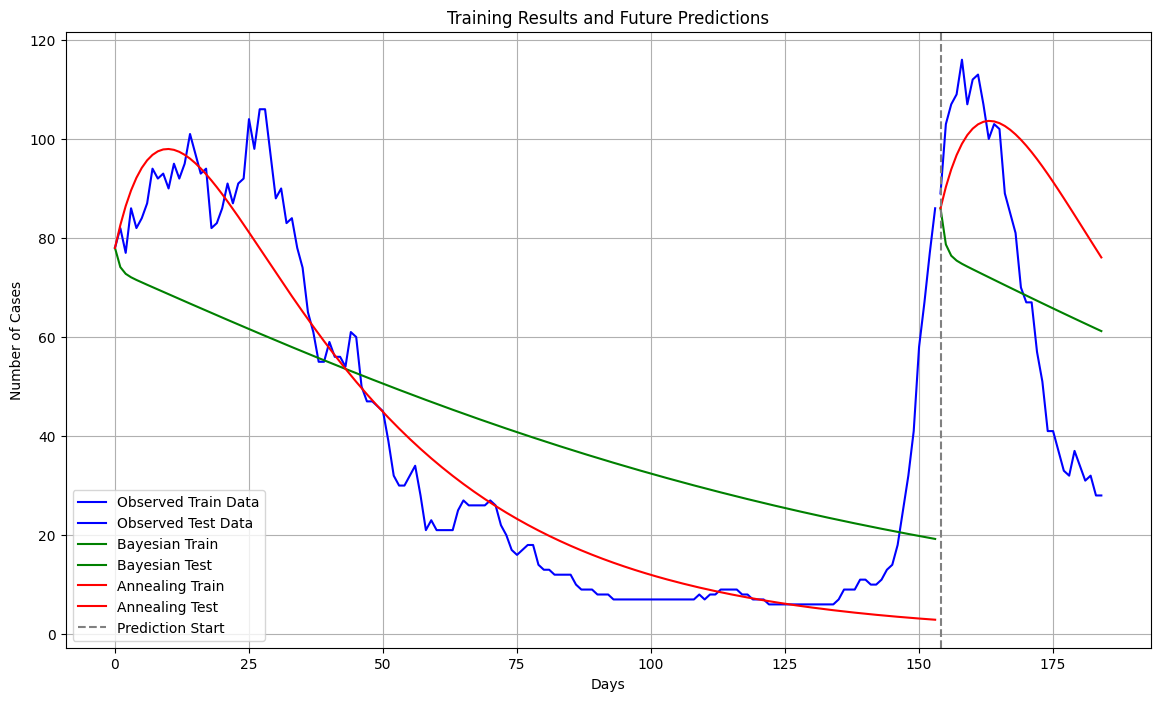

In [23]:
print("Bayesian")
print(f"MAE : {mae_bayesian}, NMAE: {nmae_bayesian}, MSE: {mse_bayesian}, RMSE: {rmse_bayesian}")
print("Simulated Annealing")
print(f"MAE : {mae_annealing}, NMAE: {nmae_annealing}, MSE: {mse_annealing}, RMSE: {rmse_annealing}")



plt.figure(figsize=(14, 8))

# Plot observed data
plt.plot(t_train, train_cases_test3,label="Observed Train Data", color="blue")
plt.plot(t_test, test_cases, label="Observed Test Data", color="blue")

# Bayesian Plot
plt.plot(t_train, I_pred_train_bayesian,label="Bayesian Train", color="green")
plt.plot(t_test, I_pred_test_bayesian, label="Bayesian Test", color="green")

# Annealing plot
plt.plot(t_train, I_pred_train_annealing,label="Annealing Train", color="red")
plt.plot(t_test, I_pred_test_annealing, label="Annealing Test", color="red")
#plt.plot(t_test, I_pred_test_seir, label="Annealing Test", color="orange")


# Add labels and legend
plt.axvline(x=len(I_pred_train_bayesian), linestyle='--', color='gray', label="Prediction Start")
plt.xlabel("Days")
plt.ylabel("Number of Cases")
plt.title("Training Results and Future Predictions")
plt.legend()
plt.grid()
plt.show()

# Test 4: 3 Months Training | 1 Month Prediction

# Bayesian

In [24]:

stan_data = {
    "n_days": n_days_train4, # number of days the model will be trained
    "t0": 0, # initial state
    "ts": np.arange(1, n_days_train4 + 1), # time steps
    "N": int(population), 
    "cases": train_cases_test4.tolist(), # active cases on different days
    "i0": train_cases_test4[0] ,  # Initial infectious individuals
    "e0":train_data_test4['count_Specimen_age_60_79'].values[0],  # Initial exposed individuals
    "r0":train_data_test4['count_Specimen_age_60_79'].values[0],  # Initial recovered individuals
}

fit = model.sample(data=stan_data, iter_warmup=500, iter_sampling=500, chains=4, parallel_chains=4,adapt_delta=0.9, seed=42)


lambda_ = np.mean(fit.stan_variable("infectious_rate"))
sigma = np.mean(fit.stan_variable("incubation_rate"))
gamma = np.mean(fit.stan_variable("recovery_rate"))
beta = lambda_
gamma = gamma

print(f'beta: {beta}, gamma: {gamma}, sigma: {sigma}')



initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test4)
t_train, t_test = get_arrange_days(train_data_test4,test_data)


predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_bayesian = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_bayesian = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)

mae_bayesian = mean_absolute_error(I_pred_test_bayesian, test_cases )
norm_factor = np.mean(np.abs(test_cases))
nmae_bayesian = mae_bayesian / norm_factor
mse_bayesian = mean_squared_error(test_cases,I_pred_test_bayesian)
rmse_bayesian = np.sqrt(mse_bayesian)


print(f"MAE : {mae_bayesian}, NMAE: {nmae_bayesian}, MSE: {mse_bayesian}, RMSE: {rmse_bayesian}")
results.append(["Test 4: Bayesian",   mse_bayesian, rmse_bayesian,mae_bayesian, nmae_bayesian,beta,  sigma,gamma])


16:24:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▋        | 00:02 Iteration:   1 / 1000 [  0%]  (Warmup)


chain 1 |██▌       | 00:09 Iteration: 100 / 1000 [ 10%]  (Warmup)


chain 1 |███▎      | 00:15 Iteration: 200 / 1000 [ 20%]  (Warmup)


chain 1 |████▏     | 00:21 Iteration: 300 / 1000 [ 30%]  (Warmup)


chain 1 |█████     | 00:25 Iteration: 400 / 1000 [ 40%]  (Warmup)




chain 1 |██████▋   | 00:31 Iteration: 501 / 1000 [ 50%]  (Sampling)
chain 1 |███████▌  | 00:35 Iteration: 600 / 1000 [ 60%]  (Sampling)


chain 1 |████████▎ | 00:40 Iteration: 700 / 1000 [ 70%]  (Sampling)


chain 1 |█████████▏| 00:45 Iteration: 800 / 1000 [ 80%]  (Sampling)
chain 1 |██████████| 00:49 Iteration: 900 / 1000 [ 90%]  (Sampling)






chain 1 |██████████| 01:02 Sampling completed                      
chain 2 |██████████| 01:02 Sampling completed                      
chain 3 |██████████| 01:02 Sampling completed                      
chain 4 |████


16:25:22 - cmdstanpy - INFO - CmdStan done processing.



beta: 0.5081865409999999, gamma: 0.49362239599999996, sigma: 0.4786023275
MAE : 33.09923843213947, NMAE: 0.4644981400617128, MSE: 1429.0407880219502, RMSE: 37.80265583291669


# Simulated Annealing

In [25]:

initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test4)
t_train, t_test = get_arrange_days(train_data_test4,test_data)

result = dual_annealing(objective_function, bounds, args=(train_cases_test4,initial_conditions,))
beta, sigma, gamma = result.x

print(f"beta: {beta}, sigma: {sigma}, gamma: {gamma}")

predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_annealing = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_annealing = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)

mae_annealing = mean_absolute_error(I_pred_test_annealing, test_cases )
norm_factor = np.mean(np.abs(test_cases))
nmae_annealing = mae_annealing / norm_factor
mse_annealing = mean_squared_error(test_cases,I_pred_test_annealing)
rmse_annealing = np.sqrt(mse_annealing)



print(f"MAE : {mae_annealing}, NMAE: {nmae_annealing}, MSE: {mse_annealing}, RMSE: {rmse_annealing}")
results.append(["Test 4: Annealing",   mse_annealing, rmse_annealing,mae_annealing, nmae_annealing,beta, sigma,gamma ])


beta: 2.0, sigma: 0.0008488093699571679, gamma: 0.06135005357462673
MAE : 24.451942586808403, NMAE: 0.34314631968812154, MSE: 942.0605032250872, RMSE: 30.693004141417752


# SEIR

In [26]:

initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test4)
t_train, t_test = get_arrange_days(train_data_test4,test_data)

beta = 2.93  # Infection rate
sigma = 0.28  # Incubation rate
gamma = 0.33  # Recovery rate


predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_seir = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_seir = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)


# Evaluate the model (using test_cases for evaluation)
mae_seir = mean_absolute_error(test_cases, I_pred_test_seir)
norm_factor = np.mean(np.abs(test_cases))
nmae_seir = mae_seir / norm_factor
mse_seir = mean_squared_error(test_cases, I_pred_test_seir)
rmse_seir = mse_seir ** (1/2)

print(f"MAE : {mae_seir}, NMAE: {nmae_seir}, MSE: {mse_seir}, RMSE: {rmse_seir}")
results.append(["Test 4: SEIR 1",   mse_seir, rmse_seir,mae_seir, nmae_seir,beta, sigma,gamma])


MAE : 38466.21400474704, NMAE: 539.8155881155084, MSE: 2856434686.735803, RMSE: 53445.62364437151


# SEIR 2

In [27]:

initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test4)
t_train, t_test = get_arrange_days(train_data_test4,test_data)

beta = 0.198  # Infection rate
sigma = 0.3  # Incubation rate
gamma = 0.1389  # Recovery rate

predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_seir2 = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_seir2 = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)


# Evaluate the model (using test_cases for evaluation)
mae_seir2 = mean_absolute_error(test_cases, I_pred_test_seir2)
norm_factor = np.mean(np.abs(test_cases))
nmae_seir2 = mae_seir2 / norm_factor
mse_seir2 = mean_squared_error(test_cases, I_pred_test_seir2)
rmse_seir2 = mse_seir2 ** (1/2)

print(f"MAE : {mae_seir2}, NMAE: {nmae_seir2}, MSE: {mse_seir2}, RMSE: {rmse_seir2}")
results.append(["Test 4: SEIR 2",   mse_seir2, rmse_seir2,mae_seir2, nmae_seir2,beta, sigma,gamma])

MAE : 107.10995006507598, NMAE: 1.503127411506272, MSE: 19109.041620488795, RMSE: 138.23545717538897


# Results

Bayesian
MAE : 33.09923843213947, NMAE: 0.4644981400617128, MSE: 1429.0407880219502, RMSE: 37.80265583291669
Simulated Annealing
MAE : 24.451942586808403, NMAE: 0.34314631968812154, MSE: 942.0605032250872, RMSE: 30.693004141417752
SEIR
MAE : 38466.21400474704, NMAE: 539.8155881155084, MSE: 2856434686.735803, RMSE: 53445.62364437151
SEIR 2
MAE : 107.10995006507598, NMAE: 1.503127411506272, MSE: 19109.041620488795, RMSE: 138.23545717538897


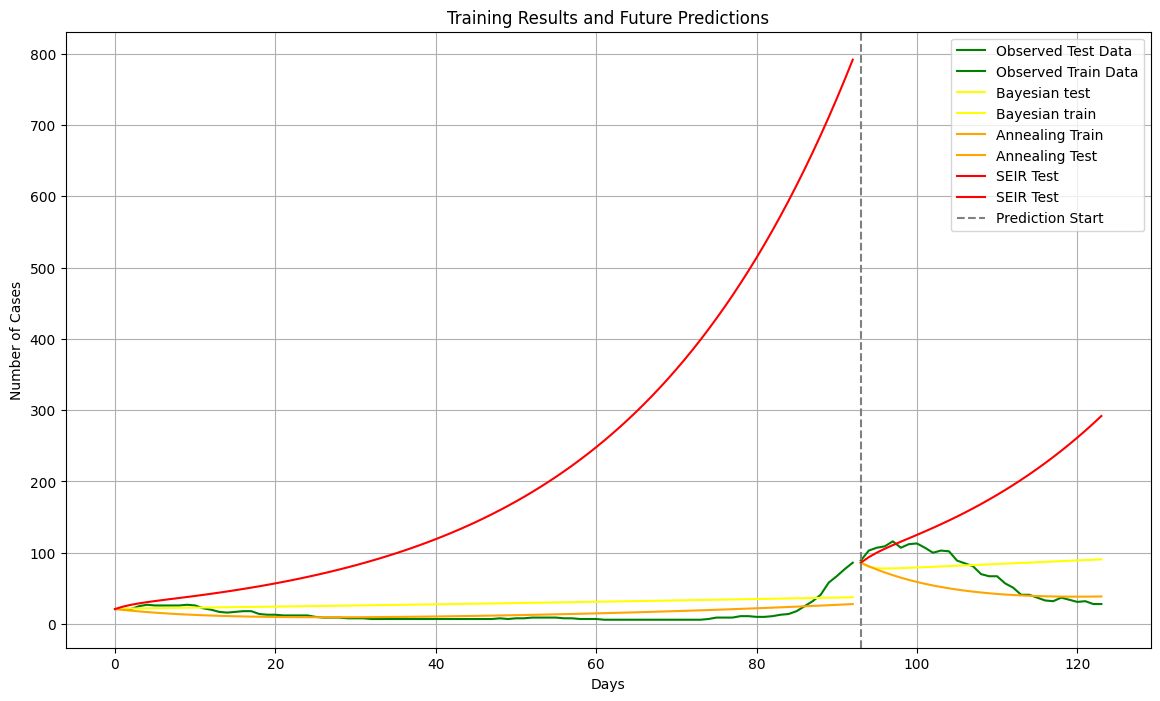

In [28]:
print("Bayesian")
print(f"MAE : {mae_bayesian}, NMAE: {nmae_bayesian}, MSE: {mse_bayesian}, RMSE: {rmse_bayesian}")
print("Simulated Annealing")
print(f"MAE : {mae_annealing}, NMAE: {nmae_annealing}, MSE: {mse_annealing}, RMSE: {rmse_annealing}")
print("SEIR")
print(f"MAE : {mae_seir}, NMAE: {nmae_seir}, MSE: {mse_seir}, RMSE: {rmse_seir}")
print("SEIR 2")
print(f"MAE : {mae_seir2}, NMAE: {nmae_seir2}, MSE: {mse_seir2}, RMSE: {rmse_seir2}")


plt.figure(figsize=(14, 8))


plt.plot(t_test, test_cases, label="Observed Test Data", color="green")
plt.plot(t_train, train_cases_test4,label="Observed Train Data", color="green")


# Plot model results for training
plt.plot(t_test, I_pred_test_bayesian, label="Bayesian test", color="yellow")
plt.plot(t_train, I_pred_train_bayesian, label="Bayesian train", color="yellow")

# Plot model results for training
plt.plot(t_train, I_pred_train_annealing,label="Annealing Train", color="orange")
plt.plot(t_test, I_pred_test_annealing, label="Annealing Test", color="orange")

plt.plot(t_test, I_pred_test_seir2, label="SEIR Test", color="red")
plt.plot(t_train, I_pred_train_seir2, label="SEIR Test", color="red")

# Add labels and legend
plt.axvline(x=len(I_pred_train_bayesian), linestyle='--', color='gray', label="Prediction Start")
plt.xlabel("Days")
plt.ylabel("Number of Cases")
plt.title("Training Results and Future Predictions")
plt.legend()
plt.grid()
plt.show()

 Wtihout SEIR

Bayesian
MAE : 33.09923843213947, NMAE: 0.4644981400617128, MSE: 1429.0407880219502, RMSE: 37.80265583291669
Simulated Annealing
MAE : 24.451942586808403, NMAE: 0.34314631968812154, MSE: 942.0605032250872, RMSE: 30.693004141417752
SEIR
MAE : 38466.21400474704, NMAE: 539.8155881155084, MSE: 2856434686.735803, RMSE: 53445.62364437151


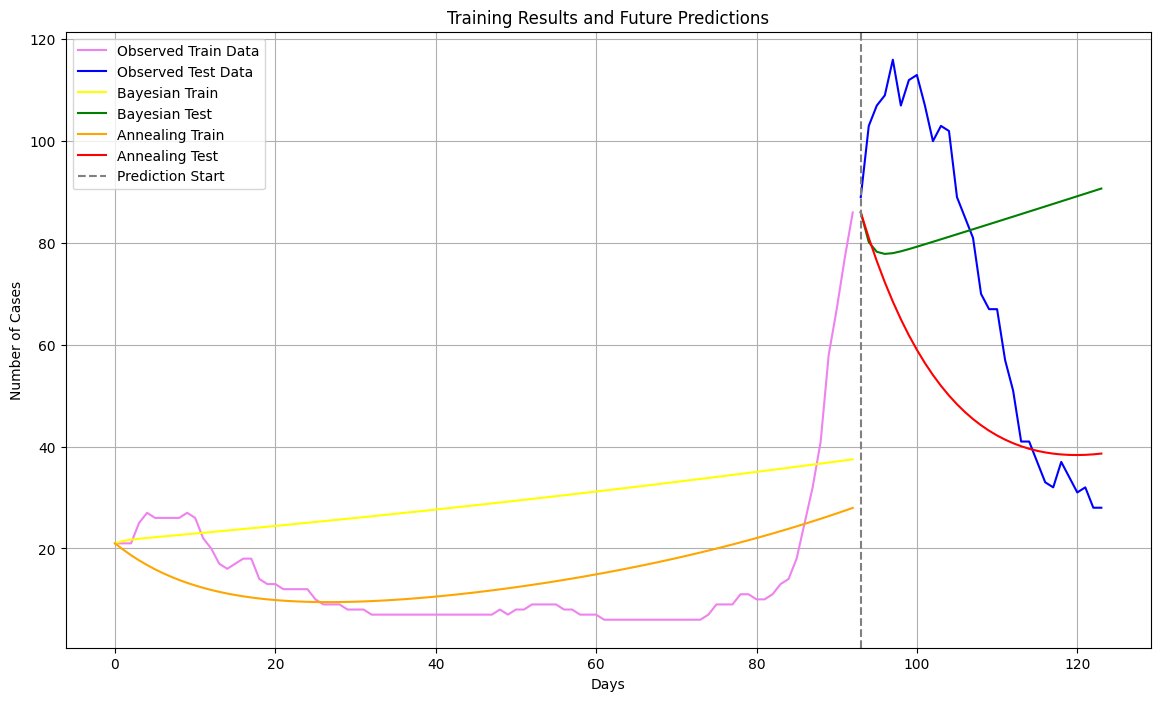

In [29]:
print("Bayesian")
print(f"MAE : {mae_bayesian}, NMAE: {nmae_bayesian}, MSE: {mse_bayesian}, RMSE: {rmse_bayesian}")
print("Simulated Annealing")
print(f"MAE : {mae_annealing}, NMAE: {nmae_annealing}, MSE: {mse_annealing}, RMSE: {rmse_annealing}")
print("SEIR")
print(f"MAE : {mae_seir}, NMAE: {nmae_seir}, MSE: {mse_seir}, RMSE: {rmse_seir}")


plt.figure(figsize=(14, 8))

# Plot observed data
plt.plot(t_train, train_cases_test4,label="Observed Train Data", color="violet")
plt.plot(t_test, test_cases, label="Observed Test Data", color="blue")

# Bayesian Plot
plt.plot(t_train, I_pred_train_bayesian,label="Bayesian Train", color="yellow")
plt.plot(t_test, I_pred_test_bayesian, label="Bayesian Test", color="green")

# Annealing plot
plt.plot(t_train, I_pred_train_annealing,label="Annealing Train", color="orange")
plt.plot(t_test, I_pred_test_annealing, label="Annealing Test", color="red")
#plt.plot(t_test, I_pred_test_seir, label="Annealing Test", color="orange")


# Add labels and legend
plt.axvline(x=len(I_pred_train_bayesian), linestyle='--', color='gray', label="Prediction Start")
plt.xlabel("Days")
plt.ylabel("Number of Cases")
plt.title("Training Results and Future Predictions")
plt.legend()
plt.grid()
plt.show()

# Download Result

In [30]:
df = pd.DataFrame(results, columns=["Test", "MSE",  "RMSE","MAE", "NMAE","Beta","Sigma", "Gamma" ])
df.to_csv("binan_result_60_79.csv", index=False)

print("Results saved to binan_result_60_79.csv")

Results saved to binan_result_60_79.csv
